In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set plotting parameters
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 0.5
rcParams['xtick.major.width'] = 0.5
rcParams['ytick.major.width'] = 0.5
rcParams['savefig.dpi'] = 300

In [3]:
import os
from catrace.publish_data import read_dataframe_from_h5

publish_data_dir = '../../publish_dataset/Hu_Temiz_et_al_dataset'

# Load behavior measures
behavior_measure_file = os.path.join(publish_data_dir, 'juvenile_dataset/behavior/juvenile_behavior_measures.h5')
behavior_measure_df = read_dataframe_from_h5(behavior_measure_file)
behavior_measure_df.reset_index(['fish_id', 'training_day'], inplace=True)
# Select the behavior measure for regression
param_name = 'CombinedZeta'
behavior_measure_name = f'auc_{param_name}_diff_per_day'

In [4]:
dataset_name = 'juvenile_dfovf'
dataset_name = 'juvenile_noise_std0p2'
dataset_name = 'juvenile_noise_std0p5'


from analysis_config import juvenile_window_name_to_frames
window_name = 'time_window_3s'
# window_name = 'time_window_5s'
window_name = 'time_window_7s'
window = juvenile_window_name_to_frames[window_name]
print(window_name, window)

fig_dir = f'../figures/{dataset_name}/{window_name}/regression_behavior'
os.makedirs(fig_dir, exist_ok=True)


time_window_7s [32, 85]


In [5]:
from catrace.publish_data import read_distance_results_from_h5
# Load the distance data
analysis_results_dir = os.path.join(publish_data_dir, f'{dataset_name}_dataset/analysis_results/{window_name}')
mahal_file = os.path.join(analysis_results_dir, 'mahal_averaged_over_repeats.h5')
center_euclidean_file = os.path.join(analysis_results_dir, 'center_euclidean_averaged_over_repeats.h5')

mahal_df = read_distance_results_from_h5(mahal_file)
center_euclidean_df = read_distance_results_from_h5(center_euclidean_file)

In [6]:
pattern_corr_file = os.path.join(analysis_results_dir, 'pattern_correlation.h5')
cosine_file = os.path.join(analysis_results_dir, 'cosine.h5')

pattern_corr_df = read_distance_results_from_h5(pattern_corr_file)
cosine_df = read_distance_results_from_h5(cosine_file)
    
# Average over trials
pattern_corr_df = pattern_corr_df.groupby(['fish_id', 'condition','odor']).mean().T.groupby('odor').mean().T
cosine_df = cosine_df.groupby(['fish_id', 'condition','odor']).mean().T.groupby('odor').mean().T

In [7]:
capacity_file = os.path.join(analysis_results_dir, 'capacity.h5')
capacity_df = read_distance_results_from_h5(capacity_file)

In [8]:
# lda_file = os.path.join(analysis_results_dir, 'lda', 'lda_matrices.h5')
# lda_df = read_distance_results_from_h5(lda_file)

P = 0.044
P = 0.037
P = 0.124
P = 0.048
P = 0.282
P = 0.014


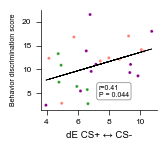

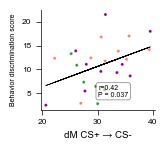

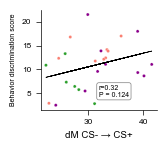

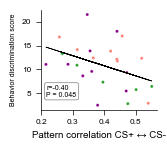

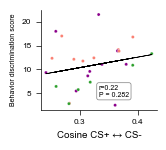

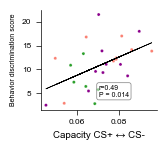

In [9]:
from catrace.run.run_correlate_with_behavior import regression_with_behavior

color_dict = {'naive': 'tab:blue', 
            'arg-phe': 'salmon',
            'phe-arg': 'darkmagenta',#'m',
            'phe-trp': 'tab:green',
}

from catrace.visualize import PlotRegressionParams
plot_regression_params = PlotRegressionParams(
    figsize=(1.8, 1.6),
    marker_size=5,
    color_dict=color_dict,
)

def plot_and_save_corr_with_metric(metric_df, metric, behavior_measure_df, behavior_measure_name, selected_conditions=None, cs_single_direction=1):
    fig, model, text_str = regression_with_behavior(metric_df, metric, behavior_measure_df, behavior_measure_name, cs_single_direction=cs_single_direction, selected_conditions=selected_conditions, plot_regression_params=plot_regression_params)

    ax = fig.get_axes()[0]
    if metric == 'mahal':
        xlabel = 'dM'
        if cs_single_direction == 1:
            cs_tag = 'CS+ → CS-'
        elif cs_single_direction == -1:
            cs_tag = 'CS- → CS+'
        else:
            raise ValueError('cs_single_direction must be 1 or -1 for mahal')
    elif metric == 'center_euclidean':
        xlabel = 'dE'
        cs_tag = 'CS+ ↔ CS-'
    elif metric == 'lda_cv_acc':
        xlabel = 'LDA Cross-validated Accuracy'
        cs_tag = 'CS+ ↔ CS-'
    else:
        xlabel = metric.replace('_', ' ').capitalize()
        cs_tag = 'CS+ ↔ CS-'
    ax.set_xlabel(f'{xlabel} {cs_tag}')
    ax.set_ylabel('Behavior discrimination score', fontsize=5)
    # Despine
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Remove legend
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    fig_name = f'behavior_vs_{metric}'
    if cs_single_direction == -1 and metric == 'mahal':
        fig_name += 'reversed'
    from catrace.for_paper import save_figure_for_paper
    save_figure_for_paper(fig, fig_name, fig_dir)
    return fig



fig = plot_and_save_corr_with_metric(center_euclidean_df, 'center_euclidean', behavior_measure_df, behavior_measure_name, cs_single_direction=1)
fig = plot_and_save_corr_with_metric(mahal_df, 'mahal', behavior_measure_df, behavior_measure_name,  cs_single_direction=1)
fig = plot_and_save_corr_with_metric(mahal_df, 'mahal', behavior_measure_df, behavior_measure_name, cs_single_direction=-1)
fig = plot_and_save_corr_with_metric(pattern_corr_df, 'pattern_correlation', behavior_measure_df, behavior_measure_name, cs_single_direction=1)
fig = plot_and_save_corr_with_metric(cosine_df, 'cosine', behavior_measure_df, behavior_measure_name, cs_single_direction=1)
fig = plot_and_save_corr_with_metric(capacity_df, 'capacity', behavior_measure_df, behavior_measure_name, cs_single_direction=1)
#fig = plot_and_save_corr_with_metric(lda_df, 'lda_cv_acc', behavior_measure_df, behavior_measure_name, cs_single_direction=1)